# X-collapsed

## GAN layers transfer of control and schizphrenia into 1 classifier

### WGAN version v4 training + testing all in one file

### 1 WGAN for schizoprenia and 1 WGAN for control



In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import glob
import nibabel as nib
import os
import matplotlib.pyplot as plt
import scipy.ndimage
import random
from tensorflow.keras.layers import Dropout, Dense, Reshape, Flatten, Conv3D, Conv3DTranspose, LeakyReLU, Input, Embedding, multiply, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split

2024-05-18 03:57:57.483915: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 03:57:57.523328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 03:57:57.523360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 03:57:57.524709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 03:57:57.532794: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# List all physical devices of type 'GPU'
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    print(f'Number of GPUs available: {len(gpus)}')
    for i, gpu in enumerate(gpus):
        print(f'GPU {i}: {gpu}')
else:
    print('No GPU detected.')

Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# full list of all schizophrenia IDs from csv, 86 in total but not all satisfy have t>90

full_schizophrenia_ids = [
    'A00009280', 'A00028806', 'A00023132', 'A00014804', 'A00016859', 'A00021598', 'A00001181', 'A00023158',
    'A00024568', 'A00028405', 'A00001251', 'A00000456', 'A00015648', 'A00002405', 'A00027391', 'A00016720',
    'A00018434', 'A00016197', 'A00027119', 'A00006754', 'A00009656', 'A00038441', 'A00012767', 'A00034273',
    'A00028404', 'A00035485', 'A00024684', 'A00018979', 'A00027537', 'A00004507', 'A00001452', 'A00023246',
    'A00027410', 'A00014719', 'A00024510', 'A00000368', 'A00019293', 'A00014830', 'A00015201', 'A00018403',
    'A00037854', 'A00024198', 'A00001243', 'A00014590', 'A00002337', 'A00024953', 'A00037224', 'A00027616',
    'A00001856', 'A00037619', 'A00024228', 'A00038624', 'A00037034', 'A00037649', 'A00022500', 'A00013216',
    'A00020787', 'A00028410', 'A00002480', 'A00028303', 'A00020602', 'A00024959', 'A00018598', 'A00014636',
    'A00019349', 'A00017147', 'A00023590', 'A00023750', 'A00031597', 'A00015518', 'A00018317', 'A00016723',
    'A00021591', 'A00023243', 'A00017943', 'A00023366', 'A00014607', 'A00020414', 'A00035003', 'A00028805',
    'A00029486', 'A00000541', 'A00028408', 'A00000909', 'A00031186', 'A00000838' ]

# schizohrenia_id that satisfy t>90, 59 in total
met_requirement_schizophrenia_ids = [
    'A00000368', 'A00000456', 'A00000541', 'A00000838', 'A00001251', 'A00001452', 'A00004507',
    'A00006754', 'A00009280', 'A00012767', 'A00013216', 'A00014607', 'A00014719', 'A00014804',
    'A00014830', 'A00015201', 'A00015648', 'A00016197', 'A00016720', 'A00016723', 'A00017147',
    'A00018317', 'A00018403', 'A00018434', 'A00018979', 'A00019293', 'A00020414', 'A00020602', 
    'A00020787', 'A00021591', 'A00021598', 'A00023158', 'A00023246', 'A00023590', 'A00023750', 
    'A00024198', 'A00024228', 'A00024568', 'A00024684', 'A00024953', 'A00024959', 'A00027410', 
    'A00027537', 'A00028303', 'A00028404', 'A00028408', 'A00028805', 'A00028806', 'A00031186', 
    'A00031597', 'A00034273', 'A00035003', 'A00035485', 'A00037034', 'A00037224', 'A00037619', 
    'A00037649', 'A00038441', 'A00038624']

full_control_ids = [
    'A00007409', 'A00013140', 'A00021145', 'A00036049', 'A00022810', 'A00002198', 'A00020895', 'A00004667',
    'A00015826', 'A00023120', 'A00022837', 'A00010684', 'A00009946', 'A00037318', 'A00033214', 'A00022490',
    'A00023848', 'A00029452', 'A00037564', 'A00036555', 'A00023095', 'A00022729', 'A00024955', 'A00024160',
    'A00011725', 'A00027487', 'A00024446', 'A00014898', 'A00015759', 'A00028409', 'A00017294', 'A00014522',
    'A00012995', 'A00031764', 'A00025969', 'A00033147', 'A00018553', 'A00023143', 'A00036916', 'A00028052',
    'A00023337', 'A00023730', 'A00020805', 'A00020984', 'A00000300', 'A00010150', 'A00024932', 'A00035537',
    'A00022509', 'A00028406', 'A00004087', 'A00035751', 'A00023800', 'A00027787', 'A00022687', 'A00023866',
    'A00021085', 'A00022619', 'A00036897', 'A00019888', 'A00021058', 'A00022835', 'A00037495', 'A00026945',
    'A00018716', 'A00026907', 'A00023330', 'A00016199', 'A00037238', 'A00023131', 'A00014120', 'A00021072',
    'A00037665', 'A00022400', 'A00003150', 'A00024372', 'A00021081', 'A00022592', 'A00022653', 'A00013816',
    'A00014839', 'A00031478', 'A00014225', 'A00013363', 'A00037007', 'A00020968', 'A00024301', 'A00024820',
    'A00035469', 'A00029226', 'A00022915', 'A00022773', 'A00024663', 'A00036844', 'A00009207', 'A00024535',
    'A00022727', 'A00011265', 'A00024546'
]

 # 82 controls that met requirement
met_requirement_control_ids = [
    'A00000300', 'A00002198', 'A00003150', 'A00004087', 'A00007409', 'A00010684', 'A00011265', 'A00011725',
    'A00012995', 'A00013140', 'A00013816', 'A00014839', 'A00014898', 'A00015759', 'A00015826', 'A00018553',
    'A00018716', 'A00019888', 'A00020805', 'A00020895', 'A00020968', 'A00020984', 'A00021058', 'A00021072',
    'A00021081', 'A00021085', 'A00022400', 'A00022490', 'A00022509', 'A00022592', 'A00022619', 'A00022653',
    'A00022687', 'A00022727', 'A00022729', 'A00022773', 'A00022810', 'A00022835', 'A00022837', 'A00022915',
    'A00023095', 'A00023120', 'A00023131', 'A00023143', 'A00023330', 'A00023337', 'A00023730', 'A00023800',
    'A00023848', 'A00023866', 'A00024160', 'A00024301', 'A00024372', 'A00024446', 'A00024535', 'A00024546', 
    'A00024663', 'A00024820', 'A00024932', 'A00024955', 'A00025969', 'A00026945', 'A00027487', 'A00027787', 
    'A00028052', 'A00028406', 'A00028409', 'A00029226', 'A00029452', 'A00031478', 'A00031764', 'A00033214', 
    'A00035751', 'A00036049', 'A00036555', 'A00036844', 'A00037007', 'A00037238', 'A00037318', 'A00037495', 
    'A00037564', 'A00037665'
]

In [4]:
def build_wgan_generator(z_dim):
    # Noise input
    z_input = Input(shape=(z_dim,))

    # Generator network
    model = Sequential()
    
    # Start with a Dense layer to an initial shape that's smaller than the final target
    model.add(Dense(128 * 7 * 7 * 9, input_dim=z_dim))  # Adjust to match an initial volume
    model.add(LeakyReLU(alpha=0.01))
    model.add(Reshape((7, 7, 9, 128)))  # This is the initial volume
    
    # Begin upsampling to the desired size
    model.add(Conv3DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    # Continue upsampling
    model.add(Conv3DTranspose(32, kernel_size=3, strides=(3, 3, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    # Final upsampling step to reach just under the target size
    model.add(Conv3DTranspose(1, kernel_size=3, strides=(2, 2, 2), padding='same', activation='tanh'))

    # Output tensor
    output = model(z_input)

    return Model(z_input, output)

In [5]:
def build_wgan_critic(img_shape):
    # Image input
    img_input = Input(shape=img_shape)

    # Critic network
    x = Conv3D(64, kernel_size=3, strides=2, padding='same')(img_input)
    #x = Conv3D(32, kernel_size=3, strides=2, padding='same')(img_input)
    x = LeakyReLU(alpha=0.01)(x)

    x = Conv3D(128, kernel_size=3, strides=2, padding='same')(x)
    #x = Conv3D(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)
    
    # Output a score for realness (no sigmoid activation)
    output = Dense(1)(x)

    return Model(img_input, output)

In [6]:
def gradient_penalty(real_images, fake_images, critic):
    batch_size = tf.shape(real_images)[0]

    # Alpha for interpolation - shape: (batch_size, 1, 1, 1, 1)
    alpha = tf.random.uniform([batch_size, 1, 1, 1, 1], 0., 1.)

    # Interpolated images - shape: (batch_size, 84, 84, 72, 1)
    interpolated_images = (real_images * alpha) + (fake_images * (1 - alpha))

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        # Critic now only takes the images as input
        predictions = critic(interpolated_images, training=True)

    # Calculate the gradients with respect to the interpolated images
    gradients = tape.gradient(predictions, [interpolated_images])[0]

    # Compute the norm of the gradients - reduce over all dimensions except the batch dimension
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3, 4]))

    # Penalize the gradient norm deviation from 1
    gp = tf.reduce_mean((gradients_norm - 1.) ** 2)
    return gp

In [7]:
def resize_image(image, new_shape):
    factors = (
        new_shape[0]/image.shape[0],
        new_shape[1]/image.shape[1],
        new_shape[2]/image.shape[2]
    )
    return scipy.ndimage.zoom(image, factors, order=1)  # order=1 is bilinear interpolation

In [8]:
def train_wgan_gp(generator, critic, dataset, epochs, z_dim, lambda_gp, critic_optimizer, generator_optimizer,type):
    # Lists to keep track of losses
    critic_losses = []
    generator_losses = []

    # Directory for saving checkpoints
    checkpoint_dir_schiz = "wgan_gp_checkpoints_schiz"
    checkpoint_dir_control = "wgan_gp_checkpoints_control"
    if not os.path.exists(checkpoint_dir_schiz):
        os.makedirs(checkpoint_dir_schiz)
    
    if not os.path.exists(checkpoint_dir_control):
        os.makedirs(checkpoint_dir_control)

    for epoch in range(epochs):
        epoch_critic_loss = 0.0
        epoch_generator_loss = 0.0
        num_batches = 0
        
        for real_imgs in dataset:
            
            num_batches += 1
            # Ensure real_imgs converts to numpy array
            real_imgs_numpy = real_imgs.numpy() if isinstance(real_imgs, tf.Tensor) else real_imgs

            batch_size = real_imgs_numpy.shape[0]
            print(real_imgs.shape)
            
            # Resize real images to match the expected dimensions of the critic
            real_imgs_resized = np.array([resize_image(img, (84, 84, 72)) for img in real_imgs.numpy()])
            real_imgs_resized = np.expand_dims(real_imgs_resized, axis=-1)  # Add channel dimension

            # Train the critic
            for _ in range(5):  # Critic is often trained more frequently
                with tf.GradientTape() as tape:
                    # Generate fake images
                    z = tf.random.normal([batch_size, z_dim])
                    fake_imgs = generator(z, training=True)

                    # Get critic scores for real and fake images
                    real_output = critic(real_imgs_resized, training=True)
                    fake_output = critic(fake_imgs, training=True)

                    # Calculate critic loss
                    critic_cost = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                    gp = gradient_penalty(real_imgs_resized, fake_imgs, critic)
                    critic_loss = critic_cost + lambda_gp * gp

                # Update critic weights
                critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
                critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
                epoch_critic_loss += critic_loss

            # Train the generator
            z = tf.random.normal([batch_size, z_dim])
            

            with tf.GradientTape() as tape:
                fake_imgs = generator(z, training=True)
                fake_output = critic(fake_imgs, training=True)
                generator_loss = -tf.reduce_mean(fake_output)

            # Update generator weights
            generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
            epoch_generator_loss += generator_loss

            # print the losses for each batch
            print(f'Epoch: {epoch}, Batch: {num_batches}, Critic Loss: {critic_loss}, Generator Loss: {generator_loss}')

        # Checkpointing every n epochs
        if (epoch + 1) % 2000 == 0:
            if type == 0: # 0 is schizophrenic
                generator.save_weights(os.path.join(checkpoint_dir_schiz, f"generator_epoch_{epoch+1}.h5"))
                critic.save_weights(os.path.join(checkpoint_dir_schiz, f"critic_epoch_{epoch+1}.h5"))
                print(f"Checkpoint: Saved model weights at epoch {epoch+1}")
            else:
                generator.save_weights(os.path.join(checkpoint_dir_control, f"generator_epoch_{epoch+1}.h5"))
                critic.save_weights(os.path.join(checkpoint_dir_control, f"critic_epoch_{epoch+1}.h5"))
                print(f"Checkpoint: Saved model weights at epoch {epoch+1}")
            
        # Record the average losses for this epoch
        critic_losses.append(epoch_critic_loss / num_batches)
        generator_losses.append(epoch_generator_loss / num_batches)

    return critic_losses, generator_losses


In [9]:
def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [10]:
#random.seed(123)

In [11]:
total_accuracy = 0
total_loss = 0
num_iterations =2

for i in range(num_iterations):

    ''' data training for GAN '''
    ''' Choosing 50 random schizphrenia samples and store remaining 9 test'''
    ''' Since we are training a separate GAN for control, also choose 50 random control samples and store remaining 9 test '''

    # GAN Training Data Selection
    gan_train_ids_schiz = random.sample(met_requirement_schizophrenia_ids, 50)
    gan_test_ids_schiz = [id for id in met_requirement_schizophrenia_ids if id not in gan_train_ids_schiz]

    gan_train_ids_control = random.sample(met_requirement_control_ids, 50)
    gan_test_ids_control = [id for id in met_requirement_control_ids if id not in gan_train_ids_control]

    # since we have 82 - 50 = 32, choose 9 random for testing    
    gan_test_ids_control = random.sample(gan_test_ids_control,9)

    ''' data training for classifier '''
    ''' just use the same train set as GAN above '''

    # Classifier Training Data Selection
    classifier_train_ids = gan_train_ids_control + gan_train_ids_schiz

    # Classifier Test Data Selection
    classifier_test_ids = gan_test_ids_schiz + gan_test_ids_control

    ''' File loading '''
    # Specify the directory and file pattern
    directory_path = '../4D/'
    file_pattern = 'A*_????_func_FL_FD_RPI_DSP_MCF_SS_SM_Nui_CS_InStandard.nii.gz'

    # Construct the full path pattern
    path_pattern = f'{directory_path}/{file_pattern}'

    # Use glob to find all matching files
    matching_files = glob.glob(path_pattern)

    ''' File loading for GAN Training and classifer '''
    ''' But this time we have 2 separate GANs, 1 train on schizoprenia and 1 train on control'''
    
    classifier_image_data = []
    classifier_labels = []  # 1 for schizophrenia, 0 for non-schizophrenia
    gan_image_data_schiz = []
    gan_image_data_control = []

    for file_path in matching_files:
        filename = os.path.basename(file_path)
        file_id = filename.split('_')[0]
        
        if file_id in gan_train_ids_schiz:
            t1_img = nib.load(file_path)
            t1_data = t1_img.get_fdata()

            if t1_data.shape[3] < 90:
                continue

            t1_data_collapsed = np.sum(t1_data, axis=0) # 0 for x axis
            gan_image_data_schiz.append(t1_data_collapsed)

        if file_id in gan_train_ids_control:
            t1_img = nib.load(file_path)
            t1_data = t1_img.get_fdata()

            if t1_data.shape[3] < 90:
                continue

            t1_data_collapsed = np.sum(t1_data, axis=0)
            gan_image_data_control.append(t1_data_collapsed)

        if file_id in classifier_train_ids or file_id in classifier_test_ids:
            t1_img = nib.load(file_path)
            t1_data = t1_img.get_fdata()

            if t1_data.shape[3] < 90:
                continue

            label = 1 if file_id in met_requirement_schizophrenia_ids else 0

            # collapsed x-axis
            t1_data_collapsed = np.sum(t1_data, axis=0)
            #print('shape of x-collapsed',t1_data_collapsed.shape)
            #print('shape of y-collapsed',t1_data_collapsed.shape)
            classifier_image_data.append(t1_data_collapsed)
            classifier_labels.append(label)

    print(f"Total GAN training files processed: {len(gan_image_data_control+gan_image_data_schiz)}")
    print(f"Total classifier training/testing files processed: {len(classifier_image_data)}")
    print(f"Total labels processed: {len(classifier_labels)}")
  

    '''Determine the maximum t-dimension size '''
    max_z_size_schiz = max(img.shape[2] for img in gan_image_data_schiz)
    max_z_size_control = max(img.shape[2] for img in gan_image_data_control)
    max_z_size_classifier = max(img.shape[2] for img in classifier_image_data)

    ''' normalization '''
    image_data_normalized_schiz = [(img - np.min(img)) / (np.max(img) - np.min(img)) * 2 - 1 for img in gan_image_data_schiz]
    image_data_normalized_control = [(img - np.min(img)) / (np.max(img) - np.min(img)) * 2 - 1 for img in gan_image_data_control]
    image_data_normalized_classifier = [(img - np.min(img)) / (np.max(img) - np.min(img)) * 2 - 1 for img in classifier_image_data]

    ''' padding of images data '''
    # Pad each image to have a consistent z-dimension size
    padded_data_schiz = [np.pad(img, ((0, 0), (0, 0), (0, max_z_size_schiz - img.shape[2])), mode='constant') for img in image_data_normalized_schiz]
    padded_data_control = [np.pad(img, ((0, 0), (0, 0), (0, max_z_size_control - img.shape[2])), mode='constant') for img in image_data_normalized_control]
    padded_data_classifier = [np.pad(img, ((0, 0), (0, 0), (0, max_z_size_classifier - img.shape[2])), mode='constant') for img in image_data_normalized_classifier]
    
    # Now convert the padded data list to a numpy array
    padded_data_array_schiz = np.array(padded_data_schiz)
    padded_data_array_control = np.array(padded_data_control)
    padded_data_array_classifier = np.array(padded_data_classifier)

    ''' loading the data for WGAN training '''
    train_images_schiz = padded_data_array_schiz
    train_images_control = padded_data_array_control

    # Define batch size
    batch_size = 10


    train_dataset_schiz = tf.data.Dataset.from_tensor_slices((train_images_schiz)).shuffle(len(train_images_schiz)).batch(batch_size)
    train_dataset_control = tf.data.Dataset.from_tensor_slices((train_images_control)).shuffle(len(train_images_control)).batch(batch_size)
    
    ''' setting up parameters'''
    # Image shape and other parameters
    img_shape = (84, 84, 72, 1)
    z_dim = 100

    # Create the generator and critic
    generator = build_wgan_generator(z_dim)
    critic = build_wgan_critic(img_shape)

    critic_optimizer = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)
    generator_optimizer = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)

    epochs = 10000
    lambda_gp = 10  # Gradient penalty coefficient

    '''Train the WGAN-GP for schizophrenic'''

    critic_losses, generator_losses = train_wgan_gp(
        generator, 
        critic, 
        train_dataset_schiz, 
        epochs, 
        z_dim,
        lambda_gp, 
        critic_optimizer, 
        generator_optimizer,
        type=0
    )
    

    ''' Train WGAN for control '''
    critic_losses, generator_losses = train_wgan_gp(
        generator, 
        critic, 
        train_dataset_control, 
        epochs, 
        z_dim,
        lambda_gp, 
        critic_optimizer, 
        generator_optimizer,
        type=1
    )
    

    ''' after training, retrieve the weights of the critic for schizophrenic'''
    # Initialize lists to hold the layers of each critic model
    critic_schiz_layers = []
    critic_control_layers = []

    checkpoint_dir_schiz = '/wgan_gp_checkpoints_schiz'
    checkpoint_prefix = os.path.join(checkpoint_dir_schiz, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                    discriminator_optimizer=critic_optimizer,
                                    generator=generator,
                                    discriminator=critic)
    
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_schiz))

    for i in range(len(critic.layers)-1):  # Excluding the last layer
        layer = critic.layers[i]
        layer.trainable = False  # Freeze the layer
        critic_schiz_layers.append(layer)

    
    ''' Then retrieve the weights of the critic for control'''

    checkpoint_dir_control = '/wgan_gp_checkpoints_control'
    checkpoint_prefix = os.path.join(checkpoint_dir_control, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                    discriminator_optimizer=critic_optimizer,
                                    generator=generator,
                                    discriminator=critic)
    
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_control))

    for i in range(len(critic.layers)-1):  # Excluding the last layer
        layer = critic.layers[i]
        layer.trainable = False
        critic_control_layers.append(layer)


    ''' transfer learning '''
    
    # Define an input layer
    input_shape = (84, 84, 72, 1)  
    input_layer = Input(shape=input_shape)

    # extracting the GAN layers
    x_schiz = input_layer
    for layer in critic_schiz_layers:
        x_schiz = layer(x_schiz)

    # Apply the control critic layers to the same input
    x_control = input_layer
    for layer in critic_control_layers:
        x_control = layer(x_control)

    # Concatenate the outputs from both critics
    concatenated = Concatenate()([x_schiz, x_control])
    merged = Flatten()(concatenated)
    
    feature = Dense(256, activation='relu', name='dense_class')(merged)
    x = Dropout(0.3)(feature)
    output_layer = Dense(1, activation='sigmoid', name='dense_class_2')(x)

    # Create the model
    classifier_model = Model(inputs=input_layer, outputs=output_layer)


    ''' Prepare data before training the classifer mod '''

    # Resize each image in the padded data array
    resized_images = [resize_image(img, (84, 84, 72)) for img in padded_data_array_classifier]

    # Convert the resized data to a numpy array
    resized_images_array = np.array(resized_images)

    # Define batch size
    batch_size = 10

    # labels array corresponding to the images
    labels_array = np.array(classifier_labels)
    
    ''' train classifier normally like in transfer-learning v2'''
    # Split the data into training and evaluation sets (80% train, 20% eval)
    X_train, X_eval, y_train, y_eval = train_test_split(resized_images_array, labels_array, test_size=0.2, random_state=42)

    # Convert to TensorFlow datasets with labels
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    eval_dataset = tf.data.Dataset.from_tensor_slices((X_eval, y_eval)).batch(batch_size)

    
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history = classifier_model.fit(
        train_dataset,
        epochs=300,
        validation_data=eval_dataset
    )

    

    ''' load test images to make test set'''
    # Now proceed with loading and preprocessing the images for these IDs
    test_image_data = []
    test_labels = []
    
    test_ids = classifier_test_ids

    # Loop through the matching files and filter based on test IDs
    for file_path in matching_files:
        filename = os.path.basename(file_path)
        file_id = filename.split('_')[0]

        # Process only if the ID is in the test set
        if file_id in test_ids:
            t1_img = nib.load(file_path)
            t1_data = t1_img.get_fdata()

            # Ensure sufficient time dimension
            if t1_data.shape[3] < 90:
                continue

            # Collapse one of the axes by summing
            t1_data_collapsed = np.sum(t1_data, axis=0)

            # Resize, normalize, and add dimension as done in the training data preparation
            processed_image = resize_image(t1_data_collapsed, (84, 84, 72))
            processed_image_normalized = (processed_image - np.min(processed_image)) / (np.max(processed_image) - np.min(processed_image)) * 2 - 1
            processed_image_final = np.expand_dims(processed_image_normalized, axis=-1)

            test_image_data.append(processed_image_final)
            label = 1 if file_id in met_requirement_schizophrenia_ids else 0
            test_labels.append(label)

    # Convert to numpy arrays
    test_images_array = np.array(test_image_data)
    test_labels_array = np.array(test_labels)


    test_dataset = tf.data.Dataset.from_tensor_slices((test_images_array, test_labels_array)).batch(batch_size)
    test_loss = 0
    test_accuracy = 0
    total_samples = 0
    actual_labels = []
    predicted_labels_list = []
    # Manually iterate over the test dataset
    for images, labels in test_dataset:

        print(f"Current batch size: {len(images)}")
        # so our batch size is not consistent, use weighted average
        batch_size = len(images)
        total_samples += batch_size
        # Make predictions
        predictions = classifier_model.predict(images)

        # Calculate loss for the batch
        loss = tf.keras.losses.binary_crossentropy(labels, predictions)
        #test_loss += tf.reduce_mean(loss).numpy()
        test_loss += tf.reduce_mean(loss).numpy() * batch_size

        # Process predictions
        predicted_labels_batch = tf.cast(tf.round(predictions), dtype=tf.int64)
        predicted_labels_list.extend(predicted_labels_batch.numpy().flatten())
        actual_labels.extend(labels.numpy().flatten())

        # Calculate accuracy for the batch
        #accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predicted_labels_batch), dtype=tf.float32))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(labels, tf.int64), tf.cast(predicted_labels_batch, tf.int64)), dtype=tf.float32))
        test_accuracy += accuracy.numpy() *batch_size


    iteration_avg_loss = test_loss / total_samples
    iteration_avg_accuracy = test_accuracy / total_samples

    total_loss += iteration_avg_loss
    total_accuracy += iteration_avg_accuracy
    
    # Print test results
    print(f"Test Loss: {iteration_avg_loss}, Test Accuracy: {iteration_avg_accuracy}")
    print("Actual labels vs. Predicted labels:")
    for i in range(len(actual_labels)):
        print(f"Image {i+1}: Actual: {actual_labels[i]}, Predicted: {predicted_labels_list[i]}")

# Calculate and print the average loss and accuracy over all iterations
average_test_loss = total_loss / num_iterations
average_test_accuracy = total_accuracy / num_iterations
print(f"\nAverage Test Loss over {num_iterations} iterations: {average_test_loss}")
print(f"Average Test Accuracy over {num_iterations} iterations: {average_test_accuracy}")

Total GAN training files processed: 100
Total classifier training/testing files processed: 118
Total labels processed: 118


2024-05-18 04:04:10.205131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44657 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6


(10, 109, 91, 146)


2024-05-18 04:04:12.121488: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-18 04:04:14.676248: I external/local_xla/xla/service/service.cc:168] XLA service 0x1a272640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-18 04:04:14.676269: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-18 04:04:14.679438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716005054.760353  557091 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 0, Batch: 1, Critic Loss: -20.283931732177734, Generator Loss: -0.42242854833602905
(10, 109, 91, 146)
Epoch: 0, Batch: 2, Critic Loss: -153.85255432128906, Generator Loss: -1.9690459966659546
(10, 109, 91, 146)
Epoch: 0, Batch: 3, Critic Loss: -205.2153778076172, Generator Loss: -3.0298385620117188
(10, 109, 91, 146)
Epoch: 0, Batch: 4, Critic Loss: -337.2387390136719, Generator Loss: -5.329700946807861
(10, 109, 91, 146)
Epoch: 0, Batch: 5, Critic Loss: -295.4831237792969, Generator Loss: -4.720847129821777
(10, 109, 91, 146)
Epoch: 0, Batch: 1, Critic Loss: -459.40545654296875, Generator Loss: -5.327576160430908
(10, 109, 91, 146)
Epoch: 0, Batch: 2, Critic Loss: -344.17266845703125, Generator Loss: -5.671848297119141
(10, 109, 91, 146)
Epoch: 0, Batch: 3, Critic Loss: -546.3890380859375, Generator Loss: -8.744179725646973
(10, 109, 91, 146)
Epoch: 0, Batch: 4, Critic Loss: -481.46270751953125, Generator Loss: -8.563819885253906
(10, 109, 91, 146)
Epoch: 0, Batch: 5, Critic L

1/1 [==============================] - 0s 136ms/step


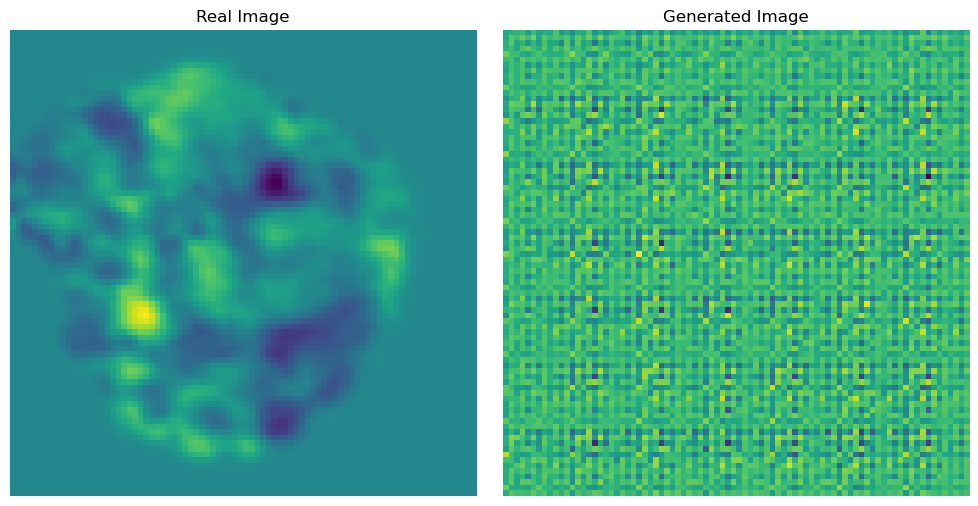

In [12]:
# Generate a single fake image
# z = np.random.normal(0, 1, (1, z_dim))
# generated_image = generator.predict(z)[0]  # [0] to get the single image from the batch

# # Get a single real image from the dataset
# real_images = next(iter(train_dataset))[0]  # the dataset yields only images

# # Take the first real image from the batch for comparison
# real_image = real_images[0]

# # Plot the real and fake images side by side
# plt.figure(figsize=(10, 5))

# # Plot real image
# plt.subplot(1, 2, 1)
# plt.imshow(real_image[:, :, 25])  # Adjust indexing and color map as needed
# plt.title('Real Image')
# plt.axis('off')

# # Plot fake image
# plt.subplot(1, 2, 2)
# plt.imshow(generated_image[:, :, 25])  # Adjust indexing and color map as needed
# plt.title('Generated Image')
# plt.axis('off')

# plt.tight_layout()
# plt.show() 


In [13]:
#generator.save('wgan_generator_model_v3.h5')
#critic.save('wgan_critic_model_v3.h5')